In [1]:
import os
import numpy as np
import pickle

from util.data_loader import load_dataset, split_train_validation, create_csv_submission, change_negative_class
from util.features_util import keep_features, merge_features
from util.features_info import FEATURES_DICT, REPLACEMENT_LIST
from util.preprocessing import preprocessing_pipeline, basic_preprocessing_pipeline
from util.train import reg_logistic_regression_hyperparameters
from util.evaluation import evaluation_summary, accuracy, f1_score
from util.util import init_random_seeds
from util.predict import predict
from util.plotting import decision_threshold

init_random_seeds()

BASE_PATH = os.path.dirname(os.getcwd()) + "/data"

In [3]:
lambdas_ = [0.00001, 0.0001, 0.001, 0.01, 0.1]
gammas = [0.01, 0.05, 0.1, 0.5, 1]
batch_sizes = [10000]

hyperparameters = {
    "lambda_": lambdas_,
    "gamma": gammas,
    "batch_size": batch_sizes,
    "optimizer": ["sgd"]
}

# THE GOOD

Iteration 0/5000 -> lowest loss inf
Iteration 200/5000 -> lowest loss 2.26396230998196
Iteration 400/5000 -> lowest loss 1.5402231794635624
Iteration 600/5000 -> lowest loss 1.0936061187891217
Iteration 800/5000 -> lowest loss 0.7909467295828011
Iteration 1000/5000 -> lowest loss 0.5922315927454638
Iteration 1200/5000 -> lowest loss 0.47174598748560653
Iteration 1400/5000 -> lowest loss 0.4022726974154776
Iteration 1600/5000 -> lowest loss 0.3599012501343742
Iteration 1800/5000 -> lowest loss 0.33116950643291043
Iteration 2000/5000 -> lowest loss 0.3102668732437795
Iteration 2200/5000 -> lowest loss 0.29433707031370065
Iteration 2400/5000 -> lowest loss 0.28177001058468704
Iteration 2600/5000 -> lowest loss 0.27171821041688576
Iteration 2800/5000 -> lowest loss 0.2634109233379626
Iteration 3000/5000 -> lowest loss 0.256717537879714
Iteration 3200/5000 -> lowest loss 0.25110052997527077
Iteration 3400/5000 -> lowest loss 0.24651679766236095
Iteration 3600/5000 -> lowest loss 0.242688021

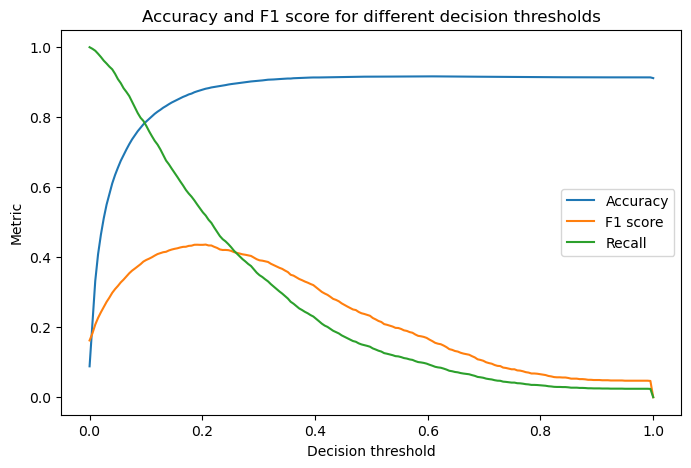

EVALUATION SUMMARY FOR BEST PARAMS (gamma=1 lambda=1e-05 batch-size=10000)
Accuracy: 88.15%
Precision: 37.60%
Recall: 51.92%
F1-score: 43.61%


In [4]:
# Load data without subsampling
x_train, y_train, x_sub, feature_names = load_dataset(path_x_train=BASE_PATH + "/x_train.csv",
                                                      path_y_train=BASE_PATH + "/y_train.csv",
                                                      path_x_test=BASE_PATH + "/x_test.csv",
                                                      sub_sample=False)
# Create the feature index dictionary
feature_index = dict(zip(feature_names, range(len(feature_names))))

############# Pre processing #############
# Pre-process the selected features
# Keeping only selected features both in train and validation set
x_train_clean, clean_features, clean_feature_index = keep_features(x_train,
                                                                   FEATURES_DICT.keys(),
                                                                   feature_names,
                                                                   feature_index,
                                                                   verbose=False)
# Call to the preprocessing pipeline both for the set of selected features
x_train_clean_proc = preprocessing_pipeline(x_train_clean,
                                            where=clean_features,
                                            feature_index=clean_feature_index,
                                            nan_replacement=REPLACEMENT_LIST,
                                            normalize="z-score")

############# Data preparation #############
# Translate labels from -1/1 to 0/1
y_train = change_negative_class(y_train[:, 1], current=-1, new=0)

# Split local data into train and validation
(x_tr, x_va, y_tr, y_va) = split_train_validation(x_train_clean_proc,
                                                  y_train,
                                                  valid_proportion=0.1)

# Add bias column to the training and validation data
x_tr_bias = np.append(x_tr, np.ones(shape=(x_tr.shape[0], 1)), axis=1)
x_va_bias = np.append(x_va, np.ones(shape=(x_va.shape[0], 1)), axis=1)


############# Grid search #############
res = reg_logistic_regression_hyperparameters(
    x_tr_bias,
    y_tr,
    x_va_bias,
    y_va,
    hyperparameters
)

with open('THE-GOOD.pkl', 'wb') as f:
    pickle.dump(res, f)

# Keep best parameters
print("THE GOOD:")
res.sort(key=lambda x: x["valid_loss"], reverse=False)
w_opt = res[0]["best_weights"]
threshold_opt = decision_threshold(x_va_bias, w_opt, y_va)

predicted_y_va = predict(x_va_bias,
                         w_opt,
                         threshold=threshold_opt,
                         negative_label=0)
# Print stats for best model
print("EVALUATION SUMMARY FOR BEST PARAMS (gamma={} lambda={} batch-size={})".format(res[0]['gamma'], res[0]['lambda_'], res[0]['batch_size']))
evaluation_summary(y_va, predicted_y_va)

# THE BAD

In [5]:
# Load data without subsampling
x_train, y_train, x_sub, feature_names = load_dataset(path_x_train=BASE_PATH + "/x_train.csv",
                                                      path_y_train=BASE_PATH + "/y_train.csv",
                                                      path_x_test=BASE_PATH + "/x_test.csv",
                                                      sub_sample=False)
# Create the feature index dictionary
feature_index = dict(zip(feature_names, range(len(feature_names))))

############# Pre processing #############
# Call to the basic preprocessing pipeline for all features 
x_train_proc = basic_preprocessing_pipeline(x_train,
                                            where=feature_names,
                                            feature_index=feature_index,
                                            normalization="z-score")

############# Data preparation #############
# Translate labels from -1/1 to 0/1
y_train = change_negative_class(y_train[:, 1], current=-1, new=0)

# Split local data into train and validation
(x_tr, x_va, y_tr, y_va) = split_train_validation(x_train_proc,
                                                  y_train,
                                                  valid_proportion=0.1)

# Add bias column to the training and validation data
x_tr_bias = np.append(x_tr, np.ones(shape=(x_tr.shape[0], 1)), axis=1)
x_va_bias = np.append(x_va, np.ones(shape=(x_va.shape[0], 1)), axis=1)


############# Grid search #############
res = reg_logistic_regression_hyperparameters(
    x_tr_bias,
    y_tr,
    x_va_bias,
    y_va,
    hyperparameters
)

with open('THE-BAD.pkl', 'wb') as f:
    pickle.dump(res, f)

# Keep best parameters
print("THE BAD:")
res.sort(key=lambda x: x["valid_loss"], reverse=False)
w_opt = res[0]["best_weights"]
threshold_opt = decision_threshold(x_va_bias, w_opt, y_va)

predicted_y_va = predict(x_va_bias,
                         w_opt,
                         threshold=threshold_opt,
                         negative_label=0)
# Print stats for best model
print("EVALUATION SUMMARY FOR BEST PARAMS (gamma={} lambda={} batch-size={})".format(res[0]['gamma'], res[0]['lambda_'], res[0]['batch_size']))
evaluation_summary(y_va, predicted_y_va)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

# THE UGLY

In [ ]:
# Load data without subsampling
x_train, y_train, x_sub, feature_names = load_dataset(path_x_train=BASE_PATH + "/x_train.csv",
                                                      path_y_train=BASE_PATH + "/y_train.csv",
                                                      path_x_test=BASE_PATH + "/x_test.csv",
                                                      sub_sample=False)
# Create the feature index dictionary
feature_index = dict(zip(feature_names, range(len(feature_names))))

x_train_clean, clean_features, clean_feature_index = keep_features(x_train,
                                                                   FEATURES_DICT.keys(),
                                                                   feature_names,
                                                                   feature_index,
                                                                   verbose=False)
# Call to the preprocessing pipeline both for the set of selected features
x_train_clean_proc = preprocessing_pipeline(x_train_clean,
                                            where=clean_features,
                                            feature_index=clean_feature_index,
                                            nan_replacement=REPLACEMENT_LIST,
                                            normalize="z-score")

# Call to a simplified version of the preprocessing pipeline on the rest of the features
x_train_dirty_proc = basic_preprocessing_pipeline(x_train,
                                                  where=[f for f in feature_names if f not in clean_features],
                                                  feature_index=feature_index,
                                                  normalization="z-score")

# Merge the results of the two preprocessing methods in one array
x_train_merged = merge_features(x_big=x_train_dirty_proc,
                                feature_index_big=feature_index,
                                x_small=x_train_clean_proc,
                                feature_index_small=clean_feature_index)


############# Data preparation #############
# Translate labels from -1/1 to 0/1
y_train = change_negative_class(y_train[:, 1], current=-1, new=0)

# Split local data into train and validation
(x_tr, x_va, y_tr, y_va) = split_train_validation(x_train_merged,
                                                  y_train,
                                                  valid_proportion=0.1)

# Add bias column to the training and validation data
x_tr_bias = np.append(x_tr, np.ones(shape=(x_tr.shape[0], 1)), axis=1)
x_va_bias = np.append(x_va, np.ones(shape=(x_va.shape[0], 1)), axis=1)

############# Grid search #############
res = reg_logistic_regression_hyperparameters(
    x_tr_bias,
    y_tr,
    x_va_bias,
    y_va,
    hyperparameters
)

with open('THE-UGLY.pkl', 'wb') as f:
    pickle.dump(res, f)

# Keep best parameters
print("THE UGLY:")
res.sort(key=lambda x: x["valid_loss"], reverse=False)
w_opt = res[0]["best_weights"]
threshold_opt = decision_threshold(x_va_bias, w_opt, y_va)

predicted_y_va = predict(x_va_bias,
                         w_opt,
                         threshold=threshold_opt,
                         negative_label=0)
# Print stats for best model
print("EVALUATION SUMMARY FOR BEST PARAMS (gamma={} lambda={} batch-size={})".format(res[0]['gamma'], res[0]['lambda_'], res[0]['batch_size']))
evaluation_summary(y_va, predicted_y_va)